# Course: Recommender systems

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# sparse matrix
from scipy.sparse import csr_matrix

# ALS
from implicit import als

# ranking model
from catboost import CatBoostClassifier, Pool

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# other
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

## Read data

In [2]:
data = pd.read_csv('./lessons/web2/retail_train.csv')
item_features = pd.read_csv('./lessons/web2/product.csv')
user_features = pd.read_csv('./lessons/web2/hh_demographic.csv')

## Process features dataset

In [3]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'
ACTUAL_COL = 'actual'

In [4]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

## Split dataset for train, eval, test

In [5]:
VAL_MATCHER_WEEKS = 3
VAL_RANKER_WEEKS = 3

In [6]:
# data for train of matching model
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# data for validation of matching model
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]

# data for train ranking model
data_train_ranker = data_val_matcher.copy()

# data for test of ranking & matching models
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [7]:
def print_stats_data(df_data: pd.DataFrame, name_df: str):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [8]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2193515, 12) Users: 2499 Items: 85334
val_matcher
Shape: (84975, 12) Users: 1889 Items: 20567
train_ranker
Shape: (84975, 12) Users: 1889 Items: 20567
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


In [9]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


## Prefilter items

In [10]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=10000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 85334 to 10001


## Make cold-start to warm-start

In [11]:
# searching for common users
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (896610, 13) Users: 2496 Items: 10001
val_matcher
Shape: (84953, 12) Users: 1887 Items: 20565
train_ranker
Shape: (84953, 12) Users: 1887 Items: 20565
val_ranker
Shape: (118282, 12) Users: 2040 Items: 24325


# Init/train recommender

In [12]:
als_params = {
    'factors': 128,
    'regularization': 0.05,
    'iterations': 10,
    'num_threads': 4,
}

recommender = MainRecommender(data_train_matcher, weighting_type='tfidf', als_params=als_params)

100%|██████████| 10001/10001 [00:00<00:00, 18182.07it/s]


## Eval recall of matching

In [13]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[829323, 835108, 836423, 851515, 875240, 87737..."
1,2,"[895388, 8357614, 12301772, 821083, 828106, 83..."


In [14]:
def evalRecall(df_result: pd.DataFrame, target_col_name: str, result_col_name: str, recommend_model: MainRecommender, actual_col: str, N_predict: int):
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=N_predict))
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[actual_col], k=N_predict), axis=1).mean()

result_params: dict = {
    'own_rec': recommender.get_own_recommendations,
    'sim_item_rec': recommender.get_similar_items_recommendation,
    # 'sim_user_rec': recommender.get_similar_users_recommendation,
    'tfidf_rec': recommender.get_tfidf_recommendations,
    'cosine_rec': recommender.get_cosine_recommendations,
    'als_rec': recommender.get_als_recommendations,
}

# N = Neighbors
N_PREDICT = 50

for rec_name, rec_model in result_params.items():
    result = evalRecall(result_eval_matcher, USER_COL, rec_name, rec_model, ACTUAL_COL, N_PREDICT)
    print('{}={}'.format(rec_name, result))

own_rec=0.04355661259958596
sim_item_rec=0.03823061952965026
tfidf_rec=0.11206874193573153
cosine_rec=0.1113275531659138
als_rec=0.08680334688028951


## The best results is TFIDFRecommender: `weight_type='tfidf'`, `tfidf_rec=0.112`

In [15]:
def calc_recall(df_data: pd.DataFrame, top_k: int, actual_col: str):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[actual_col], k=top_k), axis=1).mean()

In [16]:
def calc_precision(df_data: pd.DataFrame, top_k: int, actual_col: str):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[actual_col], k=top_k), axis=1).mean()

## Recall@50 of matching

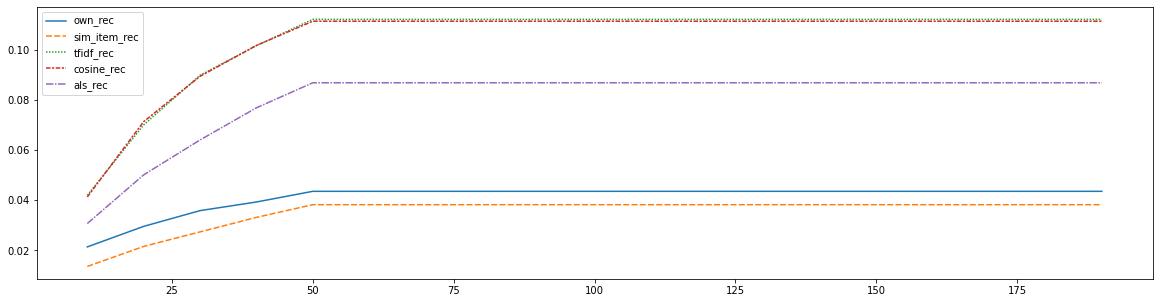

In [17]:
results_recall = dict()
for k in range(10, 200, 10):
    gen = calc_recall(result_eval_matcher, k, ACTUAL_COL)
    for itm in gen:
        if k not in results_recall:
            results_recall[k] = dict()
        results_recall[k].update({itm[0]: itm[1]})

plt.figure(figsize=(20, 5))
sns.lineplot(data=pd.DataFrame.from_dict(results_recall, orient='index'))

In [18]:
pd.DataFrame.from_dict(results_recall, orient='index').sort_values(by='tfidf_rec', ascending=False).head()

,own_rec,sim_item_rec,tfidf_rec,cosine_rec,als_rec
100,0.043557,0.038231,0.112069,0.111328,0.086803
110,0.043557,0.038231,0.112069,0.111328,0.086803
180,0.043557,0.038231,0.112069,0.111328,0.086803
170,0.043557,0.038231,0.112069,0.111328,0.086803
160,0.043557,0.038231,0.112069,0.111328,0.086803


In [19]:
results_recall[50]

{'own_rec': 0.04355661259958596,
 'sim_item_rec': 0.03823061952965026,
 'tfidf_rec': 0.11206874193573153,
 'cosine_rec': 0.1113275531659138,
 'als_rec': 0.08680334688028951}

### After k>50 recal does not change anymore

In [20]:
TOPK_RECALL = 50
TOPK_PRECISION = 5

# Ranking

## Prepare data

In [21]:
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [22]:
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_tfidf_recommendations(x, N=N_PREDICT))

In [23]:
df_match_candidates.head(2)

,user_id,candidates
0,84,"[1029743, 844179, 903529, 866211, 916122, 8681..."
1,1753,"[844179, 916122, 1029743, 1044078, 866211, 111..."


In [24]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

In [25]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [26]:
df_match_candidates.head()

,user_id,item_id
0,84,1029743
0,84,844179
0,84,903529
0,84,866211
0,84,916122


## Check warm start

In [27]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (94350, 2) Users: 1887 Items: 9287


## Create train data set for ranking

In [28]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1

df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')
df_ranker_train['target'].fillna(0, inplace= True)

df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

In [29]:
df_ranker_train.target.value_counts()

0.0    86566
1.0     9928
Name: target, dtype: int64

In [30]:
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,84,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,84,844179,0.0,2852,MEAT,National,BEEF,PRIMAL,,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [32]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [33]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price
7,2375,26984851516,1,1085983,1,2.99,364,-0.4,1642,1,0.0,0.0,2.99
11,1364,26984896261,1,842930,1,2.19,31742,0.0,1520,1,0.0,0.0,2.19


## Prepare features

In [34]:

print_stats_data(df_ranker_train, 'before featurizing')

####################
#     user_id      #
####################

# Average bill
data_train_matcher_user_group = data_train_matcher[['user_id', 'price']].groupby(['user_id'], as_index=False)\
    .agg({'price': 'mean',})\
    .rename(columns={'price': 'avg_bill',})
df_ranker_train = df_ranker_train.merge(data_train_matcher_user_group[['user_id', 'avg_bill']], on='user_id', how='left')

# Average bill per department
avg_bill_by_dep_group = df_ranker_train[['department', 'avg_bill']].groupby(['department'], as_index=False)\
    .agg({'avg_bill': 'mean'})\
    .rename(columns={'avg_bill': 'avg_bill_by_dep'})
df_ranker_train = df_ranker_train.merge(avg_bill_by_dep_group[['department', 'avg_bill_by_dep']], on='department', how='left')

####################
#     item_id      #
####################

# Average item price
data_train_matcher_item_group = data_train_matcher[['item_id', 'quantity', 'week_no', 'price']].groupby(['item_id'], as_index=False)\
    .agg({
        'quantity': 'sum',
        'week_no': 'max',
        'price': 'mean',
    })\
    .rename(columns={
        'quantity': 'total_quantity',
        'week_no': 'max_week_no',
        'price': 'avg_price',
    })
df_ranker_train = df_ranker_train.merge(data_train_matcher_item_group[['item_id', 'total_quantity', 'max_week_no', 'avg_price']], on='item_id', how='left')

# Average quantity of purchases per week
df_ranker_train['avg_quantity_per_week'] = df_ranker_train['total_quantity'] / df_ranker_train['max_week_no']

# Price / Average item price in department
item_price_dep_avg_group = df_ranker_train[['department', 'avg_price']].groupby(['department'], as_index=False)\
    .agg({'avg_price': 'mean'})\
    .rename(columns={'avg_price': 'avg_dep_price'})
df_ranker_train = df_ranker_train.merge(item_price_dep_avg_group[['department', 'avg_dep_price']], on='department', how='left')
df_ranker_train['avg_price/avg_dep_price'] = df_ranker_train['avg_price'] / df_ranker_train['avg_dep_price']

df_ranker_train.drop(['total_quantity', 'max_week_no'], axis=1, inplace=True)

# Remove trash categories
df_ranker_train.loc[df_ranker_train['kid_category_desc'] == 'None/Unknown', 'kid_category_desc'] = '-'
df_ranker_train.loc[df_ranker_train['homeowner_desc'] == 'Unknown', 'homeowner_desc'] = '-'
df_ranker_train.loc[df_ranker_train['hh_comp_desc'] == 'Unknown', 'hh_comp_desc'] = '-'
cat_feats = ['manufacturer', 'department', 'brand', 'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',
             'age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc', 'hh_comp_desc', 'household_size_desc',
             'kid_category_desc']

for feat in cat_feats:
    df_ranker_train[feat] = df_ranker_train[feat].fillna('-')
    df_ranker_train[feat] = df_ranker_train[feat].astype('category')

print_stats_data(df_ranker_train, 'after featurizing')

before featurizing
Shape: (96494, 16) Users: 1887 Items: 9287
after featurizing
Shape: (96494, 22) Users: 1887 Items: 9287


In [35]:
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,avg_bill,avg_bill_by_dep,avg_price,avg_quantity_per_week,avg_dep_price,avg_price/avg_dep_price
0,84,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,-,...,-,-,-,-,3.997935,4.084764,2.529146,133.727273,3.558547,0.710724
1,84,844179,0.0,2852,MEAT,National,BEEF,PRIMAL,,-,...,-,-,-,-,3.997935,4.112073,3.822413,50.068182,4.626368,0.826223


In [36]:
df_ranker_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96494 entries, 0 to 96493
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   user_id                  96494 non-null  int64   
 1   item_id                  96494 non-null  int64   
 2   target                   96494 non-null  float64 
 3   manufacturer             96494 non-null  category
 4   department               96494 non-null  category
 5   brand                    96494 non-null  category
 6   commodity_desc           96494 non-null  category
 7   sub_commodity_desc       96494 non-null  category
 8   curr_size_of_product     96494 non-null  category
 9   age_desc                 96494 non-null  category
 10  marital_status_code      96494 non-null  category
 11  income_desc              96494 non-null  category
 12  homeowner_desc           96494 non-null  category
 13  hh_comp_desc             96494 non-null  category
 14  househ

## Train ranking model

In [43]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

train_pool = Pool(
    X_train,
    y_train,
    cat_features=cat_feats
)

clf = CatBoostClassifier(
    eval_metric='Accuracy',
    early_stopping_rounds=50,
    depth=8,
    iterations=500,
    verbose=False,
)
clf.fit(train_pool)

## Evaluation on test dataset

In [ ]:
train_preds = clf.predict_proba(X_train)
df_ranker_predict = df_ranker_train.copy()
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [44]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


## Eval matching on test dataset

In [45]:
%%time
result_eval_ranker['tfidf_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_tfidf_recommendations(x, N=N_PREDICT))

Wall time: 34.3 s


## Eval re-ranked matched result on test dataset
    

In [46]:
def rerank(user_id: int):
    df_ = df_ranker_predict[df_ranker_predict[USER_COL]==user_id]
    return df_.sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [47]:
result_eval_ranker['reranked_tfidf_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [48]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION, ACTUAL_COL), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_tfidf_rec', 0.22469705712637048)
('tfidf_rec', 0.13490196078431374)


    ----
    baseline
    ----
    ('own_rec', 0.14441176470588235)
    ('reranked_own_rec', 0.13681462140992168)
    
    ----
    + 0.0348: optimized recall
    ----
    ('reranked_tfidf_rec', 0.1792167101827676)
    ('tfidf_rec', 0.14607843137254906)

    ----
    + 0.0071: features item_id + user_id features
    ----
    ('reranked_tfidf_rec', 0.18631853785900787)
    ('tfidf_rec', 0.14764705882352944)

    ----
    + 0.0129: VAL_MATCHER_WEEKS=5; take_n_popular=10000
    ----
    ('reranked_tfidf_rec', 0.19925333333333334)
    ('tfidf_rec', 0.1361764705882353)

    ----
    + 0.0102: VAL_MATCHER_WEEKS=4
    ----
    ('reranked_tfidf_rec', 0.2094713656387665)
    ('tfidf_rec', 0.13578431372549019)

    ----
    + 0.0083: VAL_MATCHER_WEEKS=3
    ----
    ('reranked_tfidf_rec', 0.2177726485862666)
    ('tfidf_rec', 0.13490196078431374)

    ----
    + 0.0069: changed CatBoost parameters 
    ----
    ('reranked_tfidf_rec', 0.22469705712637048)
    ('tfidf_rec', 0.13490196078431374)